In [1]:
# Taken from 
# https://github.com/scikit-image/scikit-image/blob/main/skimage/metrics/_structural_similarity.py#L12-L232

from warnings import warn
import numpy as np
from scipy.ndimage import uniform_filter, gaussian_filter

from skimage.util.dtype import dtype_range
from skimage.util.arraycrop import crop
from skimage._shared.utils import warn, check_shape_equality

__all__ = ['structural_similarity']


def structural_similarity(im1, im2,
                          *,
                          win_size=None, gradient=False, data_range=None,
                          multichannel=False, gaussian_weights=False,
                          full=False, **kwargs):
    """
    Compute the mean structural similarity index between two images.
    Parameters
    ----------
    im1, im2 : ndarray
        Images. Any dimensionality with same shape.
    win_size : int or None, optional
        The side-length of the sliding window used in comparison. Must be an
        odd value. If `gaussian_weights` is True, this is ignored and the
        window size will depend on `sigma`.
    gradient : bool, optional
        If True, also return the gradient with respect to im2.
    data_range : float, optional
        The data range of the input image (distance between minimum and
        maximum possible values). By default, this is estimated from the image
        data-type.
    multichannel : bool, optional
        If True, treat the last dimension of the array as channels. Similarity
        calculations are done independently for each channel then averaged.
    gaussian_weights : bool, optional
        If True, each patch has its mean and variance spatially weighted by a
        normalized Gaussian kernel of width sigma=1.5.
    full : bool, optional
        If True, also return the full structural similarity image.
    Other Parameters
    ----------------
    use_sample_covariance : bool
        If True, normalize covariances by N-1 rather than, N where N is the
        number of pixels within the sliding window.
    K1 : float
        Algorithm parameter, K1 (small constant, see [1]_).
    K2 : float
        Algorithm parameter, K2 (small constant, see [1]_).
    sigma : float
        Standard deviation for the Gaussian when `gaussian_weights` is True.
    Returns
    -------
    mssim : float
        The mean structural similarity index over the image.
    grad : ndarray
        The gradient of the structural similarity between im1 and im2 [2]_.
        This is only returned if `gradient` is set to True.
    S : ndarray
        The full SSIM image.  This is only returned if `full` is set to True.
    Notes
    -----
    To match the implementation of Wang et. al. [1]_, set `gaussian_weights`
    to True, `sigma` to 1.5, and `use_sample_covariance` to False.
    .. versionchanged:: 0.16
        This function was renamed from ``skimage.measure.compare_ssim`` to
        ``skimage.metrics.structural_similarity``.
    References
    ----------
    .. [1] Wang, Z., Bovik, A. C., Sheikh, H. R., & Simoncelli, E. P.
       (2004). Image quality assessment: From error visibility to
       structural similarity. IEEE Transactions on Image Processing,
       13, 600-612.
       https://ece.uwaterloo.ca/~z70wang/publications/ssim.pdf,
       :DOI:`10.1109/TIP.2003.819861`
    .. [2] Avanaki, A. N. (2009). Exact global histogram specification
       optimized for structural similarity. Optical Review, 16, 613-621.
       :arxiv:`0901.0065`
       :DOI:`10.1007/s10043-009-0119-z`
    """
    check_shape_equality(im1, im2)

    if multichannel:
        # loop over channels
        args = dict(win_size=win_size,
                    gradient=gradient,
                    data_range=data_range,
                    multichannel=False,
                    gaussian_weights=gaussian_weights,
                    full=full)
        args.update(kwargs)
        nch = im1.shape[-1]
        mssim = np.empty(nch)
        if gradient:
            G = np.empty(im1.shape)
        if full:
            S = np.empty(im1.shape)
        for ch in range(nch):
            ch_result = structural_similarity(im1[..., ch],
                                              im2[..., ch], **args)
            if gradient and full:
                mssim[..., ch], G[..., ch], S[..., ch] = ch_result
            elif gradient:
                mssim[..., ch], G[..., ch] = ch_result
            elif full:
                mssim[..., ch], S[..., ch] = ch_result
            else:
                mssim[..., ch] = ch_result
        mssim = mssim.mean()
        if gradient and full:
            return mssim, G, S
        elif gradient:
            return mssim, G
        elif full:
            return mssim, S
        else:
            return mssim

    K1 = kwargs.pop('K1', 0.01)
    K2 = kwargs.pop('K2', 0.03)
    sigma = kwargs.pop('sigma', 1.5)
    if K1 < 0:
        raise ValueError("K1 must be positive")
    if K2 < 0:
        raise ValueError("K2 must be positive")
    if sigma < 0:
        raise ValueError("sigma must be positive")
    use_sample_covariance = kwargs.pop('use_sample_covariance', True)

    if gaussian_weights:
        # Set to give an 11-tap filter with the default sigma of 1.5 to match
        # Wang et. al. 2004.
        truncate = 3.5

    if win_size is None:
        if gaussian_weights:
            # set win_size used by crop to match the filter size
            r = int(truncate * sigma + 0.5)  # radius as in ndimage
            win_size = 2 * r + 1
        else:
            win_size = 7   # backwards compatibility

    if np.any((np.asarray(im1.shape) - win_size) < 0):
        raise ValueError(
            "win_size exceeds image extent.  If the input is a multichannel "
            "(color) image, set multichannel=True.")

    if not (win_size % 2 == 1):
        raise ValueError('Window size must be odd.')

    if data_range is None:
        if im1.dtype != im2.dtype:
            warn("Inputs have mismatched dtype.  Setting data_range based on "
                 "im1.dtype.", stacklevel=2)
        dmin, dmax = dtype_range[im1.dtype.type]
        data_range = dmax - dmin

    ndim = im1.ndim

    if gaussian_weights:
        filter_func = gaussian_filter
        filter_args = {'sigma': sigma, 'truncate': truncate}
    else:
        filter_func = uniform_filter
        filter_args = {'size': win_size}

    # ndimage filters need floating point data
    im1 = im1.astype(np.float64)
    im2 = im2.astype(np.float64)

    NP = win_size ** ndim

    # filter has already normalized by NP
    if use_sample_covariance:
        cov_norm = NP / (NP - 1)  # sample covariance
    else:
        cov_norm = 1.0  # population covariance to match Wang et. al. 2004

    # compute (weighted) means
    ux = filter_func(im1, **filter_args)
    uy = filter_func(im2, **filter_args)
   
    # compute (weighted) variances and covariances
    uxx = filter_func(im1 * im1, **filter_args)
    uyy = filter_func(im2 * im2, **filter_args)
    uxy = filter_func(im1 * im2, **filter_args)
    vx = cov_norm * (uxx - ux * ux)
    vy = cov_norm * (uyy - uy * uy)
    vxy = cov_norm * (uxy - ux * uy)

    R = data_range
    C1 = (K1 * R) ** 2
    C2 = (K2 * R) ** 2

    A1, A2, B1, B2 = ((2 * ux * uy + C1,
                       2 * vxy + C2,
                       ux ** 2 + uy ** 2 + C1,
                       vx + vy + C2))
    D = B1 * B2
    S = (A1 * A2) / D
    
    # to avoid edge effects will ignore filter radius strip around edges
    pad = (win_size - 1) // 2

    # compute (weighted) mean of ssim
    mssim = crop(S, pad).mean()
    
    if gradient:
        # The following is Eqs. 7-8 of Avanaki 2009.
        grad = filter_func(A1 / D, **filter_args) * im1
        grad += filter_func(-S / B2, **filter_args) * im2
        grad += filter_func((ux * (A2 - A1) - uy * (B2 - B1) * S) / D,
                            **filter_args)
        grad *= (2 / im1.size)

        if full:
            return mssim, grad, S
        else:
            return mssim, grad
    else:
        if full:
            return mssim, S
        else:
            return mssim

In [2]:
import matplotlib.pyplot as plt

def write_csv(name, m):
    sourceFile = open(name, 'w')
    strm = str(m)
    print(strm[1:-1], file = sourceFile)
    sourceFile.close()
    
def show(ims):
    plt.figure(figsize=(5*len(ims),5))
    
    for i in range(len(ims)):
        plt.subplot(1,len(ims),i+1)
        plt.imshow(ims[i])
        
def ssim(im1, im2):
    return structural_similarity(im1, im2, gaussian_weights=True, sigma=1.5, use_sample_covariance=False, data_range=255)
  

In [9]:
gt = np.load('data/gt.npy').astype(int)
pred = np.load('data/pred.npy').astype(int)
print(gt.shape)

# renormalize
for i in range(gt.shape[0]):
    m = max(gt[i,:,:].max(), pred[i,:,:].max())
    
    gt[i,:,:] = np.floor( 255*gt[i,:,:]/m )
    pred[i,:,:] = np.floor( 255*pred[i,:,:]/m )

(100, 64, 64)


0.6991618028944135


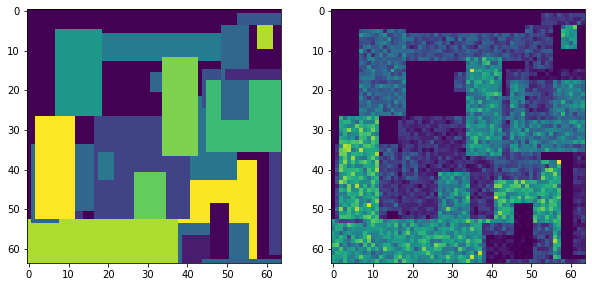

In [10]:
n = 18
print(ssim(gt[n,:,:], pred[n,:,:]))
show([gt[n,:,:], pred[n,:,:]])

In [11]:
b = gt.shape[0]
m = []
for i in range(b):
    m.append( ssim( gt[i,:,:], pred[i,:,:] ) )
    
print(m)

[0.7413397108955339, 0.443145581646387, 0.30121793310771255, 0.9324147986242435, 0.5499968873675875, 0.34763999999649847, 0.6275392226573409, 0.6168069667355709, 0.42221869455895794, 0.21896660696794062, 0.30769514718816143, 0.6704971358366657, 0.26695865494690696, 0.9264564722145856, 0.7256188155498189, 0.6409567313334219, 0.18077103413126983, 0.6973077643578642, 0.6991618028944135, 0.9713955276230251, 0.338181989441683, 0.6709723932774599, 0.5742657493839138, 0.8393042172321155, 0.20825640039287008, 0.5434651036213556, 0.4978195069332686, 0.3407813245046762, 0.9993488759646865, 0.7107859545108824, 0.6446187670381144, 0.5786900332306539, 0.8987405666228748, 0.43607575828555223, 0.39983271358136646, 0.5139224434739201, 0.5108795646922426, 0.7694019726765411, 0.20045081691062747, 0.24792353337524367, 0.6696478965575986, 0.286083602086647, 0.5741779896336199, 0.5946389054060379, 0.64232584737461, 0.27470458898724964, 0.6937464917925353, 0.7886771428345886, 0.4826108498974406, 0.335139311

In [12]:
write_csv('data/ssim.txt', m)